# Computational Methods in Stochastics - Assignment 4

In [77]:
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm

In [78]:
# Global variables and Useful functions
N = 1000
mi = 60
T = 24 * mi
M = np.matrix([[6, 0.2], [8, 0.9], [12, 0.5], [15, 0.6], [17, 1.0], [19, 0.6], [24, 0.5]]) 
print(M)
def init_v():
    MC = np.empty((N, T))              
    count_first = 0 
    t_first = 0
    U = np.max(M[:,1]) 
    return MC, t_first, count_first, U

def init_inside_tqdm():
    cars = np.zeros(T)
    current_time = 0
    count = 0  
    l, _, _ = cumulative_hazard_params(current_time)
    return cars, current_time, count, l

def cumulative_hazard_params(t):
    cum_haz = 0
    l = 0
    i = t
    if(i <= M[0, 0] * mi):
        return M[l,1], int(0), int(cum_haz)
    else:
        cum_haz += M[0, 1] * M[0, 0] * mi
        i -= M[0, 0] * mi
    for j in range(1, M.shape[0]):
        if(i > (M[j, 0] - M[j-1,0]) * mi):
            cum_haz += M[j, 1] * (M[j, 0] - M[j - 1,0]) * mi
            i -= (M[j, 0] - M[j - 1,0]) * mi
        else:
            l = j
            break
    return np.round(M[l, 1], 1), int(M[l - 1, 0] * mi), cum_haz

def plot_avg(MC):
    plt.figure(figsize=(15, 4))
    plt.plot(np.arange(T), np.mean(MC, axis=0))
    plt.title("Avg number of cars")
    plt.xlabel("Time (min)")
    plt.ylabel("Avg number of cars")
    plt.show()

def plot_cumulative(MC, t_first):
    cars = np.mean(MC, axis=0)
    for i in range(1, T):
        cars[i] += cars[i - 1]

    plt.figure(figsize=(15, 4))
    plt.scatter(np.arange(T), cars)
    plt.title("Cumulative number of cars")
    plt.xlabel("Time (min)")
    plt.ylabel("Cumulative number of cars")
    plt.show()

    print(f"Average time when the first car arrived: {t_first}")
    print(f"Average number of cars that arrived in 24 hours: {int(np.sum(MC) / N)}")
    return cars


[[ 6.   0.2]
 [ 8.   0.9]
 [12.   0.5]
 [15.   0.6]
 [17.   1. ]
 [19.   0.6]
 [24.   0.5]]


## Revised Algorithm For Sampling Events In Order

100%|██████████| 1000/1000 [00:27<00:00, 36.11it/s]


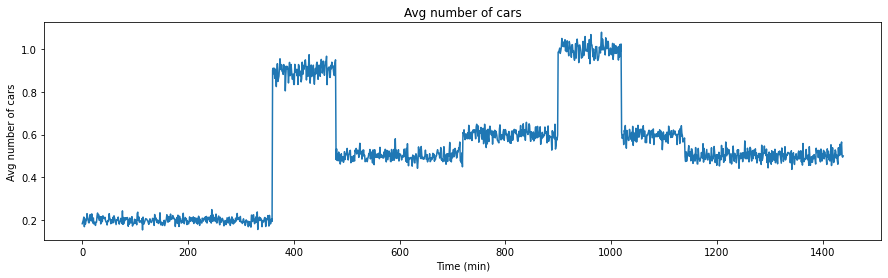

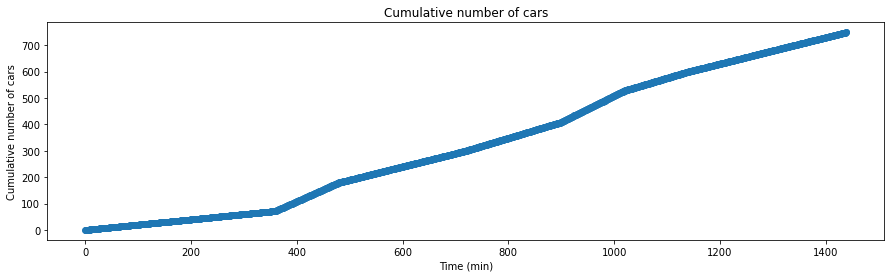

Average time when the first car arrived: 5.061573409983652
Average number of cars that arrived in 24 hours: 749


In [79]:
MC_revised, t_first, count_first, U = init_v()    
for k in tqdm(range(N)):
    cars, current_time, count, l = init_inside_tqdm()
    arrival_rate = U * T
    poisson_param = np.random.poisson(arrival_rate) 
    for i in range(1, poisson_param + 1):
        u = np.random.rand()
        current_time += (T-current_time)*(1 - u**(1 / (poisson_param - i + 1)))
        u = np.random.rand() * U
        S, _, _ = cumulative_hazard_params(current_time)
        if(current_time <= T and u <= S):
            cars[int(np.floor(current_time))]+=1
            if (count == 0):                 
                count += 1            
                t_first += current_time            
                count_first += 1        
        MC_revised[k] = cars
t_first /= count_first  
# avg cars/min
plot_avg(MC_revised)
# avg cumulative cars/min
cars_revised = plot_cumulative(MC_revised, t_first)

## Thinning Algorithm

100%|██████████| 1000/1000 [00:29<00:00, 34.06it/s]


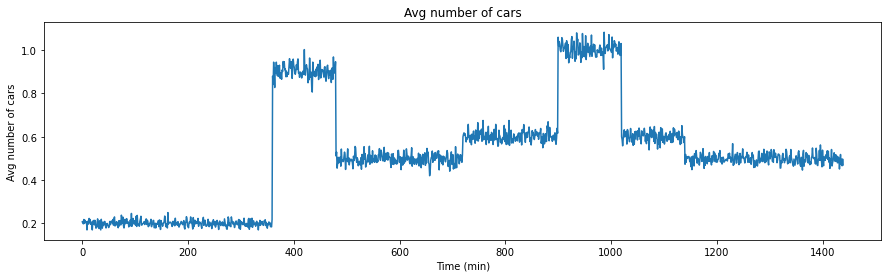

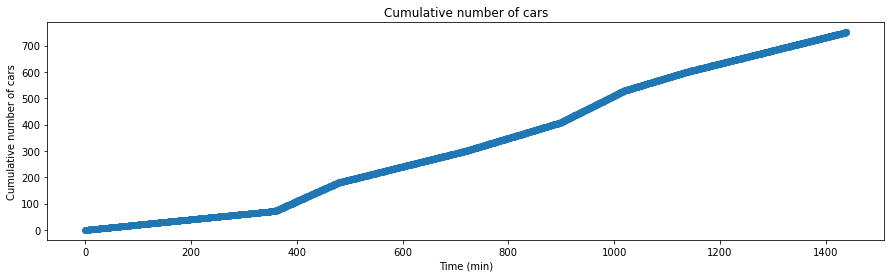

Average time when the first car arrived: 4.922965091327204
Average number of cars that arrived in 24 hours: 750


In [80]:
MC_thinning, t_first, count_first, U = init_v()    
for k in tqdm(range(N)):
    cars, current_time, count, l = init_inside_tqdm()
    while(current_time <= T):
        u = np.random.rand()
        current_time += -np.log(1-u)/U
        u = np.random.rand()
        l, _, _ = cumulative_hazard_params(current_time)
        if(current_time <= T and u < l / U):
            cars[int(np.floor(current_time))]+=1
            if (count == 0):
                count += 1
                t_first += current_time
                count_first += 1
        MC_thinning[k] = cars
t_first /= count_first
# avg cars/min
plot_avg(MC_thinning)
# avg cumulative cars/min
cars_thinning = plot_cumulative(MC_thinning, t_first)

## Comparison of Methods

Note that observing the following plots and numbers indicate that the algorithms simulating the **inhomogeneous Poisson process** work properly.

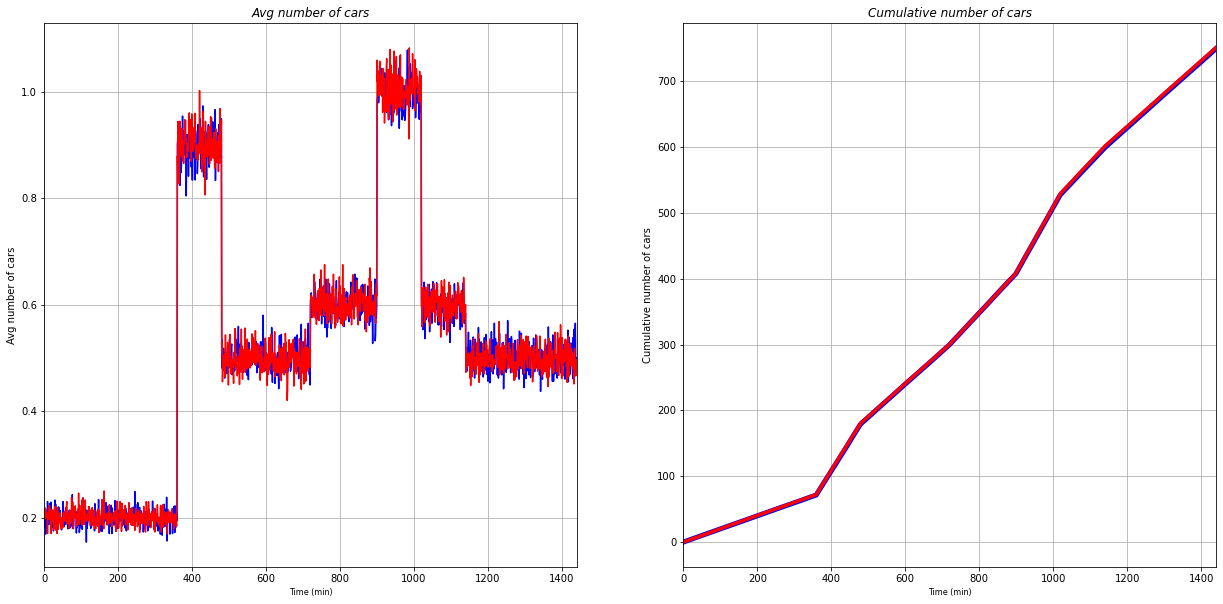

In [81]:
# Compare all 4 plots
fig, axs = plt.subplots(1, 2, figsize = [21, 10])
x_axis = np.arange(T)

axs[0].plot(x_axis, np.mean(MC_revised, axis=0), c= "blue")
axs[0].plot(x_axis, np.mean(MC_thinning, axis=0), c= "red")
axs[0].set_xlim(0,T)
axs[0].set_xlabel ('Time (min)', fontsize = 8)
axs[0].set_ylabel ('Avg number of cars', fontsize = 10)
axs[0].set_title(f'Avg number of cars', fontstyle = 'italic')
axs[0].grid()

axs[1].plot(x_axis, cars_revised, c= "blue", linewidth = '5')
axs[1].plot(x_axis, cars_thinning, c= "red", linewidth = '3.5')
axs[1].set_xlim(0,T)
axs[1].set_xlabel ('Time (min)', fontsize = 8)
axs[1].set_ylabel ('Cumulative number of cars', fontsize = 10)
axs[1].set_title(f'Cumulative number of cars', fontstyle = 'italic')
axs[1].grid()